# Process and Plot Summaries


# Imports and Members

In [1]:
# Imports
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
import os

In [2]:
# Matplotlib settings
plt.rcParams.update({'font.size': 24})

In [3]:
# Prepare Member
thresholds = [0.0, 0.1, 0.5]
threshold_sessions = ['0', '01', '05']
threshold_legend = ['0.0', '0.1', '0.5']
buckets = [3, 11, 41]
bucket_sessions = ['3', '11', '41']
sb_mult_sessions = ['A']
bro_mult_sessions = ['A']
run_id_prefix_bro = 'bro'
run_id_prefix_sb = 'sb'
run_id_prefix_t = '_thresh_'
run_id_prefix_b = '_bucket_'
run_id_prefix_m = '_multi_'
num_runs = 10
colorTheme = np.array(['darkgray','lightsalmon','powderblue','lightcoral', 'plum', 'black', 'red'])

# Functions: Read event and CSV data
processSummary reads in the run_id and number of runs. It collects all the values specified by the value_tag and computes the mean of all runs if set to true. This function returns 3 pandas Dataframes: values, times, steps.

In [4]:
def processSummary(run_id, num_runs, value_tag, brain_name = '', create_mean = True):
    
    # Read data
    # generate list of directory path
    events = []
    for run in range(num_runs):
        events.append(EventAccumulator('summaries/' + run_id + '-' + str(run) + brain_name))
        events[run].Reload()
    
    # Prepare data
    _times = []
    _values = []
    _steps = []

    for run in events:
        times, steps, values = zip(*run.Scalars(value_tag))
        _times.append(times)
        _values.append(values)
        _steps.append(steps)
    
    _times = np.asarray(_times)
    _steps = np.asarray(_steps)
    _values = np.asarray(_values)
    
    print(np.shape(_values))
    
    _values = np.swapaxes(_values,0,1)
    _times = np.swapaxes(_times,0,1)
    
    # Reduce _steps to one column and reshape it
    _steps = _steps[0]
    _steps.shape = (_steps.size, 1)
    
    # Create data frames
    dfValues = pd.DataFrame(data=_values)
    dfTimes = pd.DataFrame(data=_times)
    dfSteps = pd.DataFrame(data=_steps)

    if create_mean:
        # Add mean column
        dfValues['mean'] = dfValues.mean(axis=1)
        # Add std column
        droppedMean = dfValues.drop(['mean'], axis=1)
        dfValues['std'] = droppedMean.std(axis=1)
        
    return dfValues, dfTimes, dfSteps

processCSV reads in all csv files found under the run_id. It collects all the values and computes the mean of all runs if set to true. This function returns 2 pandas Dataframes: values, steps.

In [5]:
def processCSV(run_id, delimiter=',', create_mean = True):
    # get csv files of the run_id
    filePaths = os.listdir('./csv/' + run_id)
    # Read csvs and merge to pandas data frame
    for i in range(len(filePaths)):
        if i == 0:
            dfValues = pd.read_csv('./csv/' + run_id + '/' + filePaths[i], delimiter = delimiter)
        else:
            a = pd.read_csv('./csv/' + run_id + '/' + filePaths[i], delimiter = delimiter)
            dfValues = pd.merge(dfValues, a, on='steps', how='outer')
    
    dfValues.columns = ['step', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    dfSteps = dfValues['step']
    # Drop steps
    dfValues = dfValues.drop(['step'], axis = 1)
    
    if create_mean:
        # Add mean column
        dfValues['mean'] = dfValues.mean(axis=1)
        # Add std column
        droppedMean = dfValues.drop(['mean'], axis=1)
        dfValues['std'] = droppedMean.std(axis=1)
        
    return dfValues, dfSteps

# Load data

In [6]:
# BRO
# Threshold
bro_cum_array = []# Cumulative Reward
bro_el_array = [] # Episode Length
bro_time_array = []

for session in range(len(threshold_sessions)):
    run_id = run_id_prefix_bro + run_id_prefix_t + threshold_sessions[session] 
    cum_values, times, bro_steps = processSummary(run_id, num_runs, 'Environment/Cumulative Reward', '_BROThresholdBrain')
    el_values, times, bro_steps = processSummary(run_id, num_runs, 'Environment/Episode Length', '_BROThresholdBrain')
    bro_cum_array.append(cum_values)
    bro_el_array.append(el_values)
    bro_time_array.append(times)
    
# Bucket
bro_b_cum_array = []# Cumulative Reward
bro_b_el_array = [] # Episode Length
bro_b_time_array = []

for session in range(len(bucket_sessions)):
    run_id = run_id_prefix_bro + run_id_prefix_b + bucket_sessions[session] 
    cum_values, times, bro_steps = processSummary(run_id, num_runs, 'Environment/Cumulative Reward', '_BROBucketedBrain')
    el_values, times, bro_steps = processSummary(run_id, num_runs, 'Environment/Episode Length', '_BROBucketedBrain')
    bro_b_cum_array.append(cum_values)
    bro_b_el_array.append(el_values)
    bro_b_time_array.append(times)
    
# Multiagent
bro_m_cum_array = [] # Cumulative Reward
bro_m_el_array = [] # Episode Length
bro_m_time_array = []

for session in range(len(bro_mult_sessions)):
    run_id = run_id_prefix_bro + run_id_prefix_m + bro_mult_sessions[session]
    cum_values, times, bro_steps = processSummary(run_id, num_runs, 'Environment/Cumulative Reward', '_BROClickingBrain')
    el_values, times, bro_steps = processSummary(run_id, num_runs, 'Environment/Episode Length', '_BROClickingBrain')
    bro_m_cum_array.append(cum_values)
    bro_m_el_array.append(el_values)
    bro_m_time_array.append(times)

INFO:tensorflow:No path found after summaries/bro_thresh_0-0_BROThresholdBrain\events.out.tfevents.1552755494.cstd01-070
INFO:tensorflow:No path found after summaries/bro_thresh_0-1_BROThresholdBrain\events.out.tfevents.1552755495.cstd01-070
INFO:tensorflow:No path found after summaries/bro_thresh_0-2_BROThresholdBrain\events.out.tfevents.1552755496.cstd01-070
INFO:tensorflow:No path found after summaries/bro_thresh_0-3_BROThresholdBrain\events.out.tfevents.1552755496.cstd01-070
INFO:tensorflow:No path found after summaries/bro_thresh_0-4_BROThresholdBrain\events.out.tfevents.1552755497.cstd01-070
INFO:tensorflow:No path found after summaries/bro_thresh_0-5_BROThresholdBrain\events.out.tfevents.1552755498.cstd01-070
INFO:tensorflow:No path found after summaries/bro_thresh_0-6_BROThresholdBrain\events.out.tfevents.1552755499.cstd01-070
INFO:tensorflow:No path found after summaries/bro_thresh_0-7_BROThresholdBrain\events.out.tfevents.1552755500.cstd01-070
INFO:tensorflow:No path found af

INFO:tensorflow:No path found after summaries/bro_bucket_3-7_BROBucketedBrain\events.out.tfevents.1552627909.cstd01-071
INFO:tensorflow:No path found after summaries/bro_bucket_3-8_BROBucketedBrain\events.out.tfevents.1552627910.cstd01-071
INFO:tensorflow:No path found after summaries/bro_bucket_3-9_BROBucketedBrain\events.out.tfevents.1552627911.cstd01-071
(10, 100)
INFO:tensorflow:No path found after summaries/bro_bucket_3-0_BROBucketedBrain\events.out.tfevents.1552627903.cstd01-071
INFO:tensorflow:No path found after summaries/bro_bucket_3-1_BROBucketedBrain\events.out.tfevents.1552627904.cstd01-071
INFO:tensorflow:No path found after summaries/bro_bucket_3-2_BROBucketedBrain\events.out.tfevents.1552627905.cstd01-071
INFO:tensorflow:No path found after summaries/bro_bucket_3-3_BROBucketedBrain\events.out.tfevents.1552627906.cstd01-071
INFO:tensorflow:No path found after summaries/bro_bucket_3-4_BROBucketedBrain\events.out.tfevents.1552627906.cstd01-071
INFO:tensorflow:No path found 

INFO:tensorflow:No path found after summaries/bro_multi_A-5_BROClickingBrain\events.out.tfevents.1552627904.cstd01-080
INFO:tensorflow:No path found after summaries/bro_multi_A-6_BROClickingBrain\events.out.tfevents.1552627905.cstd01-080
INFO:tensorflow:No path found after summaries/bro_multi_A-7_BROClickingBrain\events.out.tfevents.1552627905.cstd01-080
INFO:tensorflow:No path found after summaries/bro_multi_A-8_BROClickingBrain\events.out.tfevents.1552627906.cstd01-080
INFO:tensorflow:No path found after summaries/bro_multi_A-9_BROClickingBrain\events.out.tfevents.1552627907.cstd01-080
(10, 100)


In [7]:
# SB
# Threshold
sb_cum_array = [] # Cumulative Reward
sb_acc_array = [] # Click Accuracy
sb_time_array = []

for session in range(len(threshold_sessions)):
    run_id = run_id_prefix_sb + run_id_prefix_t + threshold_sessions[session] 
    cum_values, times, sb_steps = processSummary(run_id, num_runs, 'Environment/Cumulative Reward', '_SBThresholdBrain')
    sb_cum_array.append(cum_values)
    sb_time_array.append(times)
    accuracy, sb_steps = processCSV(run_id, ',')
    sb_acc_array.append(accuracy)

# Bucket
sb_b_cum_array = [] # Cumulative Reward
sb_b_acc_array = [] # Click Accuracy
sb_b_time_array = []

for session in range(len(bucket_sessions)):
    run_id = run_id_prefix_sb + run_id_prefix_b + bucket_sessions[session] 
    cum_values, times, sb_steps = processSummary(run_id, num_runs, 'Environment/Cumulative Reward', '_SBBucketedBrain')
    sb_b_cum_array.append(cum_values)
    sb_b_time_array.append(times)
    accuracy, sb_steps = processCSV(run_id, ',')
    sb_b_acc_array.append(accuracy)
    
# Multiagent
sb_m_cum_array = [] # Cumulative Reward
sb_m_acc_array = [] # Click Accuracy
sb_m_time_array = []

for session in range(len(sb_mult_sessions)):
    run_id = run_id_prefix_sb + run_id_prefix_m + sb_mult_sessions[session]
    cum_values, times, sb_steps = processSummary(run_id, num_runs, 'Environment/Cumulative Reward', '_SBClickingBrain')
    sb_m_cum_array.append(cum_values)
    sb_m_time_array.append(times)
    accuracy, sb_steps = processCSV(run_id, ',')
    sb_m_acc_array.append(accuracy)

INFO:tensorflow:No path found after summaries/sb_thresh_0-0_SBThresholdBrain\events.out.tfevents.1552627899.cstd01-091
INFO:tensorflow:No path found after summaries/sb_thresh_0-1_SBThresholdBrain\events.out.tfevents.1552627900.cstd01-091
INFO:tensorflow:No path found after summaries/sb_thresh_0-2_SBThresholdBrain\events.out.tfevents.1552627901.cstd01-091
INFO:tensorflow:No path found after summaries/sb_thresh_0-3_SBThresholdBrain\events.out.tfevents.1552627901.cstd01-091
INFO:tensorflow:No path found after summaries/sb_thresh_0-4_SBThresholdBrain\events.out.tfevents.1552627902.cstd01-091
INFO:tensorflow:No path found after summaries/sb_thresh_0-5_SBThresholdBrain\events.out.tfevents.1552627903.cstd01-091
INFO:tensorflow:No path found after summaries/sb_thresh_0-6_SBThresholdBrain\events.out.tfevents.1552627903.cstd01-091
INFO:tensorflow:No path found after summaries/sb_thresh_0-7_SBThresholdBrain\events.out.tfevents.1552627904.cstd01-091
INFO:tensorflow:No path found after summaries/sb

INFO:tensorflow:No path found after summaries/sb_multi_A-9_SBClickingBrain\events.out.tfevents.1552755502.cstd01-227
(10, 100)


# Plots
## Threshold

In [8]:
# Shared formatting
def plotThresh(y_min_lim, y_max_lim, title, y_label):
    plt.ylim(y_min_lim, y_max_lim)
    plt.xlabel('Steps')
    plt.ylabel(y_label)
    plt.title(title)

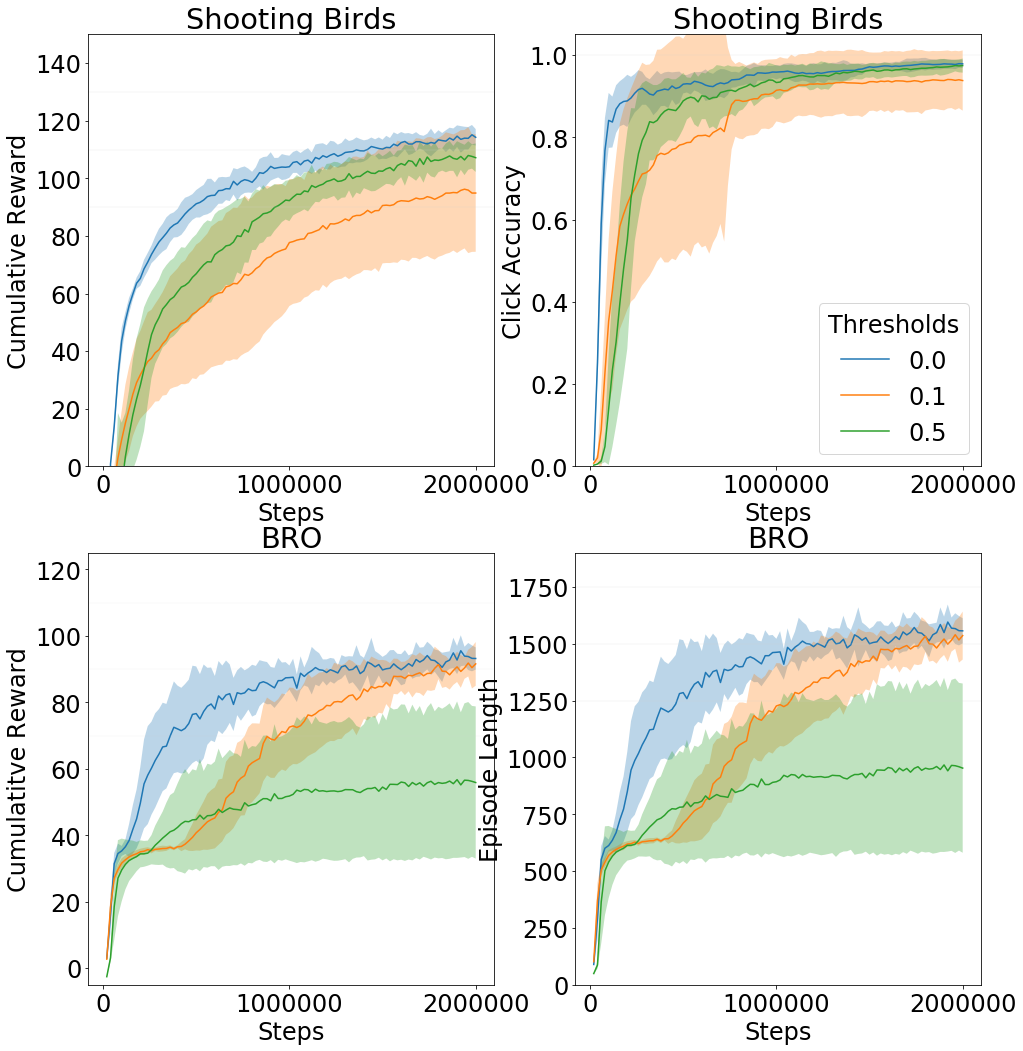

In [9]:
# Start Line Plot
fig,ax = plt.subplots()
plt.clf()
plt.subplots_adjust(bottom = 0.0, top = 1.2)

### SB ###
# Cumulative reward
plt.subplot(2, 2, 1)
for session in range(3):
    plt.plot(sb_steps, sb_cum_array[session]['mean'])
    plt.fill_between(sb_steps, sb_cum_array[session]['mean']+sb_cum_array[session]['std'],
                     sb_cum_array[session]['mean']-sb_cum_array[session]['std'], alpha=0.3)
plotThresh(0, 150, 'Shooting Birds', 'Cumulative Reward') # y limit arguments (min/max), title, y_label
plt.axhline(130, color='lightgrey', linewidth = 0.2, label='_nolegend_')
plt.axhline(110, color='lightgrey', linewidth = 0.2, label='_nolegend_')
plt.axhline(90, color='lightgrey', linewidth = 0.2, label='_nolegend_')
plt.xticks([0, 1000000, 2000000])

# Click Accuracy
plt.subplot(2, 2, 2)
for session in range(3):
    plt.plot(sb_steps, sb_acc_array[session]['mean'])
    plt.fill_between(sb_steps, sb_acc_array[session]['mean']+sb_acc_array[session]['std'],
                     sb_acc_array[session]['mean']-sb_acc_array[session]['std'], alpha=0.3)
plotThresh(0, 1.05, 'Shooting Birds', 'Click Accuracy') # y limit arguments (min/max), title, y_label
plt.axhline(1, color='lightgrey', linewidth = 0.2, label='_nolegend_')
plt.legend(['0.0', '0.1', '0.5'], title='Thresholds', loc='lower right')
plt.xticks([0, 1000000, 2000000])

### BRO ###
# Cumulative reward
plt.subplot(2, 2, 3)
for session in range(3):
    plt.plot(bro_steps, bro_cum_array[session]['mean'])
    plt.fill_between(sb_steps, bro_cum_array[session]['mean']+bro_cum_array[session]['std'], bro_cum_array[session]['mean']-bro_cum_array[session]['std'], alpha=0.3)
plotThresh(-5, 125, 'BRO', 'Cumulatitve Reward') # y limit arguments (min/max), title, y_label
plt.axhline(70, color='lightgrey', linewidth = 0.1, label='_nolegend_')
plt.axhline(90, color='lightgrey', linewidth = 0.1, label='_nolegend_')
plt.axhline(110, color='lightgrey', linewidth = 0.1, label='_nolegend_')
plt.xticks([0, 1000000, 2000000])

# Episode length
plt.subplot(2, 2, 4)
for session in range(3):
    plt.plot(bro_steps, bro_el_array[session]['mean'])
    plt.fill_between(sb_steps, bro_el_array[session]['mean']+bro_el_array[session]['std'], bro_el_array[session]['mean']-bro_el_array[session]['std'], alpha=0.3)
plotThresh(0, 1900, 'BRO', 'Episode Length') # y limit arguments (min/max), title, y_label
plt.axhline(1750, color='lightgrey', linewidth = 0.2, label='_nolegend_')
plt.axhline(1500, color='lightgrey', linewidth = 0.2, label='_nolegend_')
plt.axhline(1250, color='lightgrey', linewidth = 0.2, label='_nolegend_')
#plt.legend(['0.0', '0.1', '0.5'], title='Thresholds', loc='lower right')
plt.xticks([0, 1000000, 2000000])

fig = plt.gcf()
fig.set_size_inches(16, 11)
plt.show()
with PdfPages('./plots/threshold_results.pdf') as pdf:
    pdf.savefig(fig, bbox_inches='tight')

## Bucket

In [10]:
# Shared formatting
def plotBuckets(y_min_lim, y_max_lim, y_label, title):
    plt.ylim(y_min_lim, y_max_lim)
    plt.xlabel('Steps')
    plt.ylabel(y_label)
    plt.title(title)

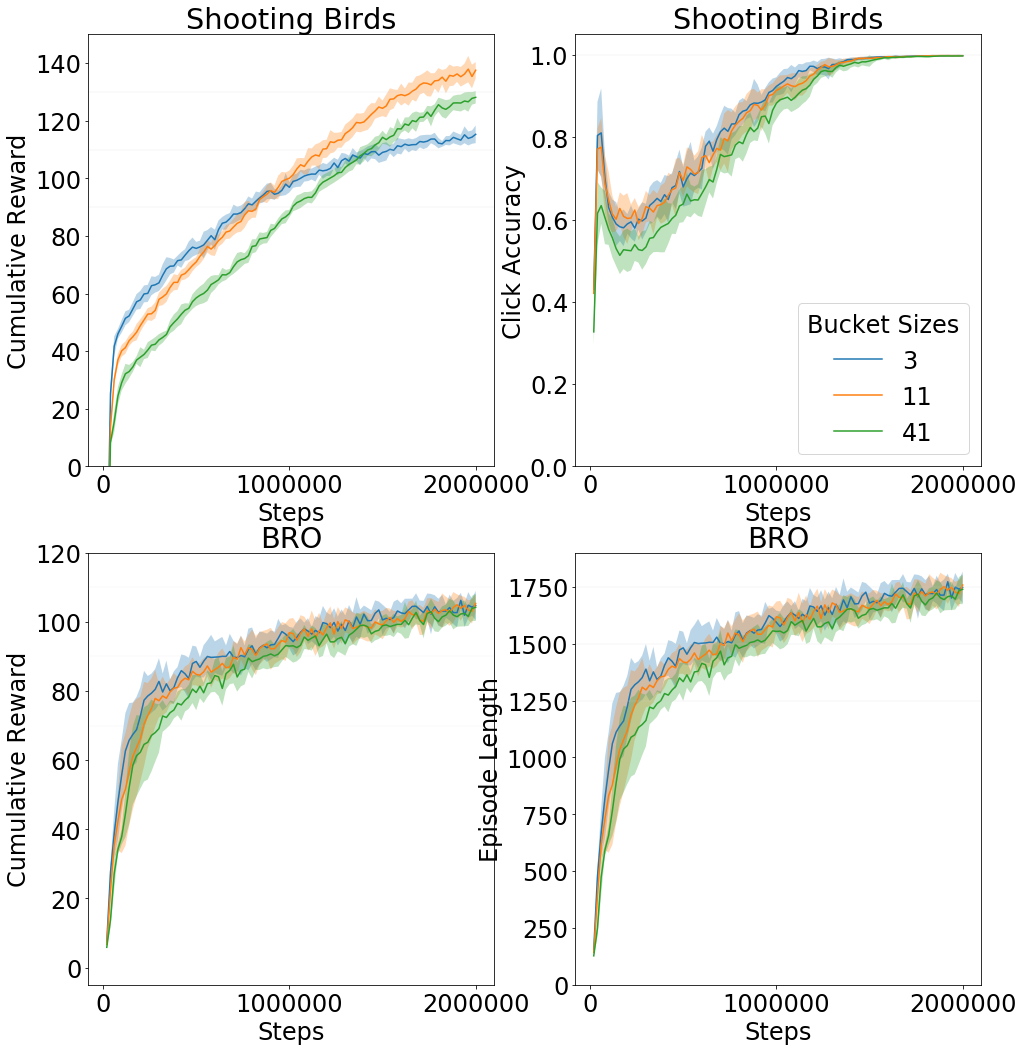

In [11]:
# Start line Plot
fig = plt.figure()
plt.clf()
plt.subplots_adjust(bottom = 0.0, top = 1.2)

### SB ###
# Cumulative reward
plt.subplot(2, 2, 1)
for session in range(len(bucket_sessions)):
    plt.plot(sb_steps, sb_b_cum_array[session]['mean'])
    plt.fill_between(sb_steps, sb_b_cum_array[session]['mean']+sb_b_cum_array[session]['std'],
                 sb_b_cum_array[session]['mean']-sb_b_cum_array[session]['std'], alpha=0.3)
plotBuckets(0, 150, 'Cumulative Reward', 'Shooting Birds')
plt.axhline(130, color='lightgrey', linewidth = 0.2, label='_nolegend_')
plt.axhline(110, color='lightgrey', linewidth = 0.2, label='_nolegend_')
plt.axhline(90, color='lightgrey', linewidth = 0.2, label='_nolegend_')
plt.xticks([0, 1000000, 2000000])

# Click Accuracy
plt.subplot(2, 2, 2)
for session in range(len(bucket_sessions)):
    plt.plot(sb_steps, sb_b_acc_array[session]['mean'])
    plt.fill_between(sb_steps, sb_b_acc_array[session]['mean']+sb_b_acc_array[session]['std'],
             sb_b_acc_array[session]['mean']-sb_b_acc_array[session]['std'], alpha=0.3)
plotBuckets(0, 1.05, 'Click Accuracy', 'Shooting Birds')
plt.axhline(1, color='lightgrey', linewidth = 0.2, label='_nolegend_')
plt.legend(['3', '11', '41'], title='Bucket Sizes', loc='lower right')
plt.xticks([0, 1000000, 2000000])

### BRO ###
# Cumulative reward
plt.subplot(2, 2, 3)
for session in range(len(bucket_sessions)):
    plt.plot(bro_steps, bro_b_cum_array[session]['mean'])
    plt.fill_between(sb_steps, bro_b_cum_array[session]['mean']+bro_b_cum_array[session]['std'],
                 bro_b_cum_array[session]['mean']-bro_b_cum_array[session]['std'], alpha=0.3)
plotBuckets(-5, 120, 'Cumulative Reward', 'BRO')
plt.axhline(70, color='lightgrey', linewidth = 0.1, label='_nolegend_')
plt.axhline(90, color='lightgrey', linewidth = 0.1, label='_nolegend_')
plt.axhline(110, color='lightgrey', linewidth = 0.1, label='_nolegend_')
plt.xticks([0, 1000000, 2000000])

# Episode length
plt.subplot(2, 2, 4)
for session in range(len(bucket_sessions)):
    plt.plot(bro_steps, bro_b_el_array[session]['mean'])
    plt.fill_between(sb_steps, bro_b_el_array[session]['mean']+bro_b_el_array[session]['std'],
                 bro_b_el_array[session]['mean']-bro_b_el_array[session]['std'], alpha=0.3)
plotBuckets(0, 1900, 'Episode Length', 'BRO')
plt.axhline(1750, color='lightgrey', linewidth = 0.2, label='_nolegend_')
plt.axhline(1500, color='lightgrey', linewidth = 0.2, label='_nolegend_')
plt.axhline(1250, color='lightgrey', linewidth = 0.2, label='_nolegend_')
#plt.legend(['3', '11', '41'], title='Bucket Sizes', loc='lower right')
plt.xticks([0, 1000000, 2000000])

fig = plt.gcf()
fig.set_size_inches(16, 11)
plt.show()
with PdfPages('./plots/bucket_results.pdf') as pdf:
    pdf.savefig(fig, bbox_inches='tight')

## All (inc. multiagent)

In [12]:
# Combine threshold and bucket results

# Function to prepare data
def combine_mean(dataframe):
    df = dataframe[0]['mean'].to_frame()
    df.columns = ['0']
    for session in range(1, len(dataframe)):
        df[str(session)] = dataframe[session]['mean']
    # Add mean
    df['mean'] = df.mean(axis=1)
    # Add std
    droppedMean = df.drop(['mean'], axis=1)
    df['std'] = droppedMean.std(axis=1)
    return df

### BRO Cumulative Reward
bro_thresh_cum_all = combine_mean(bro_cum_array)
bro_b_cum_all = combine_mean(bro_b_cum_array)
### BRO Episode Length
bro_thresh_el_all = combine_mean(bro_el_array)
bro_b_el_all = combine_mean(bro_b_el_array)
### SB Cumulative Reward
sb_thresh_cum_all = combine_mean(sb_cum_array)
sb_b_cum_all = combine_mean(sb_b_cum_array)
### SB Click Accuracy
sb_thresh_acc_all = combine_mean(sb_acc_array)
sb_b_acc_all = combine_mean(sb_b_acc_array)

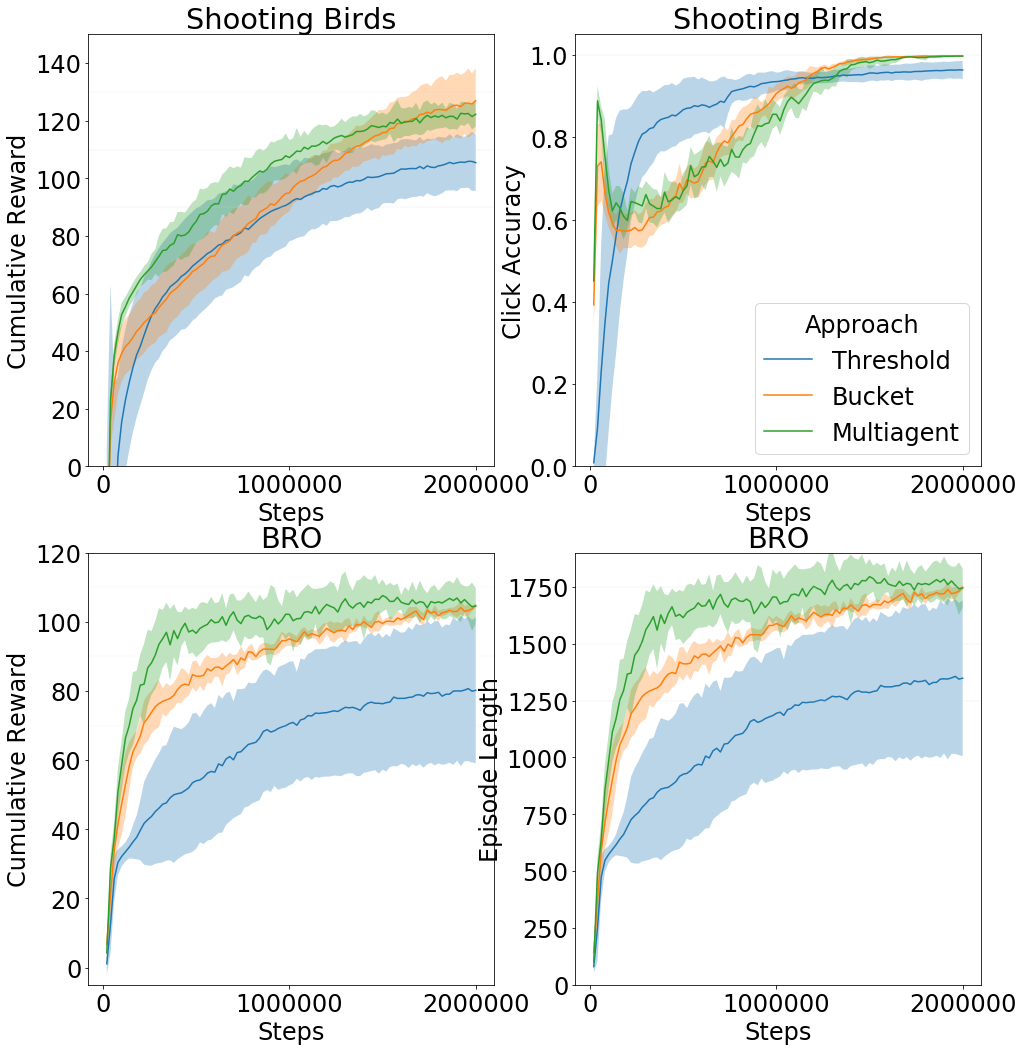

In [13]:
# Start Line Plot
fig = plt.figure()
plt.clf()
plt.subplots_adjust(bottom = 0.0, top = 1.2)

# SB Cumulative Reward T vs B
plt.subplot(2, 2, 1)
plt.plot(sb_steps, sb_thresh_cum_all['mean'])
plt.fill_between(sb_steps, sb_thresh_cum_all['mean']+sb_thresh_cum_all['std'], sb_thresh_cum_all['mean']-sb_thresh_cum_all['std'], alpha=0.3)
plt.plot(sb_steps, sb_b_cum_all['mean'])
plt.fill_between(sb_steps, sb_b_cum_all['mean']+sb_b_cum_all['std'], sb_b_cum_all['mean']-sb_b_cum_all['std'], alpha=0.3)
plt.plot(sb_steps, sb_m_cum_array[0]['mean'])
plt.fill_between(sb_steps, sb_m_cum_array[0]['mean']+sb_m_cum_array[0]['std'], sb_m_cum_array[0]['mean']-sb_m_cum_array[0]['std'], alpha=0.3)
plt.axhline(130, color='lightgrey', linewidth = 0.2, label='_nolegend_')
plt.axhline(110, color='lightgrey', linewidth = 0.2, label='_nolegend_')
plt.axhline(90, color='lightgrey', linewidth = 0.2, label='_nolegend_')
plt.ylim(0, 150)
plt.xlabel('Steps')
plt.ylabel('Cumulative Reward')
plt.title('Shooting Birds')
plt.xticks([0, 1000000, 2000000])

# SB Click Accuracy T vs B
plt.subplot(2, 2, 2)
plt.plot(sb_steps, sb_thresh_acc_all['mean'])
plt.fill_between(sb_steps, sb_thresh_acc_all['mean']+sb_thresh_acc_all['std'], sb_thresh_acc_all['mean']-sb_thresh_acc_all['std'], alpha=0.3)
plt.plot(sb_steps, sb_b_acc_all['mean'])
plt.fill_between(sb_steps, sb_b_acc_all['mean']+sb_b_acc_all['std'], sb_b_acc_all['mean']-sb_b_acc_all['std'], alpha=0.3)
plt.plot(sb_steps, sb_m_acc_array[0]['mean'])
plt.fill_between(sb_steps, sb_m_acc_array[0]['mean']+sb_m_acc_array[0]['std'], sb_m_acc_array[0]['mean']-sb_m_acc_array[0]['std'], alpha=0.3)
plt.axhline(1, color='lightgrey', linewidth = 0.2, label='_nolegend_')
plt.ylim(0, 1.05)
plt.xlabel('Steps')
plt.ylabel('Click Accuracy')
plt.legend(['Threshold', 'Bucket', 'Multiagent'], title='Approach', loc='lower right')
plt.title('Shooting Birds')
plt.xticks([0, 1000000, 2000000])

# BRO Cumulative reward T vs B
plt.subplot(2, 2, 3)
plt.plot(sb_steps, bro_thresh_cum_all['mean'])
plt.fill_between(bro_steps[0], bro_thresh_cum_all['mean']+bro_thresh_cum_all['std'], bro_thresh_cum_all['mean']-bro_thresh_cum_all['std'], alpha=0.3)
plt.plot(sb_steps, bro_b_cum_all['mean'])
plt.fill_between(bro_steps[0], bro_b_cum_all['mean']+bro_b_cum_all['std'], bro_b_cum_all['mean']-bro_b_cum_all['std'], alpha=0.3)
plt.plot(sb_steps, bro_m_cum_array[0]['mean'])
plt.fill_between(bro_steps[0], bro_m_cum_array[0]['mean']+bro_m_cum_array[0]['std'], bro_m_cum_array[0]['mean']-bro_m_cum_array[0]['std'], alpha=0.3)
plt.axhline(70, color='lightgrey', linewidth = 0.1, label='_nolegend_')
plt.axhline(90, color='lightgrey', linewidth = 0.1, label='_nolegend_')
plt.axhline(110, color='lightgrey', linewidth = 0.1, label='_nolegend_')
plt.ylim(-5, 120)
plt.xlabel('Steps')
plt.ylabel('Cumulative Reward')
plt.title('BRO')
plt.xticks([0, 1000000, 2000000])

# BRO Episode Length T vs B
plt.subplot(2, 2, 4)
plt.plot(sb_steps, bro_thresh_el_all['mean'])
plt.fill_between(bro_steps[0], bro_thresh_el_all['mean']+bro_thresh_el_all['std'], bro_thresh_el_all['mean']-bro_thresh_el_all['std'], alpha=0.3)
plt.plot(sb_steps, bro_b_el_all['mean'])
plt.fill_between(bro_steps[0], bro_b_el_all['mean']+bro_b_el_all['std'], bro_b_el_all['mean']-bro_b_el_all['std'], alpha=0.3)
plt.plot(sb_steps, bro_m_el_array[0]['mean'])
plt.fill_between(bro_steps[0], bro_m_el_array[0]['mean']+bro_m_el_array[0]['std'], bro_m_el_array[0]['mean']-bro_m_el_array[0]['std'], alpha=0.3)
plt.axhline(1750, color='lightgrey', linewidth = 0.2, label='_nolegend_')
plt.axhline(1500, color='lightgrey', linewidth = 0.2, label='_nolegend_')
plt.axhline(1250, color='lightgrey', linewidth = 0.2, label='_nolegend_')
plt.ylim(0, 1900)
plt.xlabel('Steps')
plt.ylabel('Episode Length')
#plt.legend(['Threshold', 'Bucket', 'Multiagent'], title='Approach', loc='lower right')
plt.title('BRO')
plt.xticks([0, 1000000, 2000000])

fig = plt.gcf()
fig.set_size_inches(16, 11)
plt.show()
with PdfPages('./plots/overall_results.pdf') as pdf:
    pdf.savefig(fig, bbox_inches='tight')